In [31]:
# 3-1. 형태소 분석

import scipy as sp
import pandas as pd
import numpy as np

from konlpy.tag import Kkma        ; kkma = Kkma()
from konlpy.tag import Hannanum    ; hannanum = Hannanum()
from konlpy.tag import Okt         ; t = Okt()     # 구 트위터
from konlpy.tag import *
import nltk
import pickle

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# %matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz

import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [32]:
# 형태소 분석을 수행할 수 있도록 먼저 데이터를 불러온 후 뉴스제목들을 '\n' 으로 구분하여 한 문자열에 담아줍니다.
news_df = pd.read_csv('news_titles.csv')
news_df = news_df.dropna(axis=0)
title_list = news_df.뉴스제목.values.tolist()
title_text =  '\n'.join(title_list)

# 전체 문자열을 형태소 단위로 쪼개어 토큰의 개수를 세어보면 토큰 전체 개수는 373006개, 토큰 unique 개수는 14298개가 출력
tokens_ko = t.morphs(title_text)
ko = nltk.Text(tokens_ko)

stop_words = ['\n',"'",'…',',','[',']','(',')','"','주','에','코스닥','특징','종목','·','장','코스피','증시','-','적',\
            '도','기술','분석','마감','‘','`','요약','가','’','의','이','오전','★','은','“','대','”','한','B','로',\
            '?','3','선','A','오후','는','5','!','"…','상','들','1','만에','제','2','…"','20','일','서','명',"'…",'기',\
            '···','10','소','등','으로','자','전','률','미','...','50','세','시','안','폭',"…'",'만','9','VI','까지',\
            '눈','더','e','량','고','인','52','성','띄네','1%','부터','다','감','을','지','4','에도','수','7','것','째',\
            '체크','기','···','중','계','관련','왜','1억원','총','내','과','젠','또','연','엔','차','굿모닝','할','8','.',\
            '보다','새','주간','전망','추천','이슈','플러스','사','개월','때','..','임','속','’…','G','나','개','원','에서',\
            '하는','이유','달','→','권','?…','단독','간','배','30','K','저','와','하','/','1조','6','두','해야','분','형',\
            '황','공','&','앞두고','보','문','이번','익','X','1억',']"','치','산','를','오','해','S','우리','그','된','준','▶',\
            '건','재','반','라','10년','초','3분','월','신','p','급','조','줄','경','했다','구','진','이어','올','발','vs','강',\
            '국','9억','1년','난','판','면','"(','`…','살','아','인데','번','텍','팜','8월','Q','메','2년','점','하고','10월',\
            'D','비','됐다','채',"]'",'보니','손','확','종','동','팔','40','타','~','9월','2100','30%','땐','말','한다','요',\
            "',",'스','…`','단','16','길','12','3억','회','될까','호','용','2조','번째','일까','듯','최',"↑","↓"]
tokens_ko = [each_word for each_word in tokens_ko
            if each_word not in stop_words]
ko = nltk.Text(tokens_ko)


In [33]:
# 그래프에서 한글 폰트가 깨질 경우 실행
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)


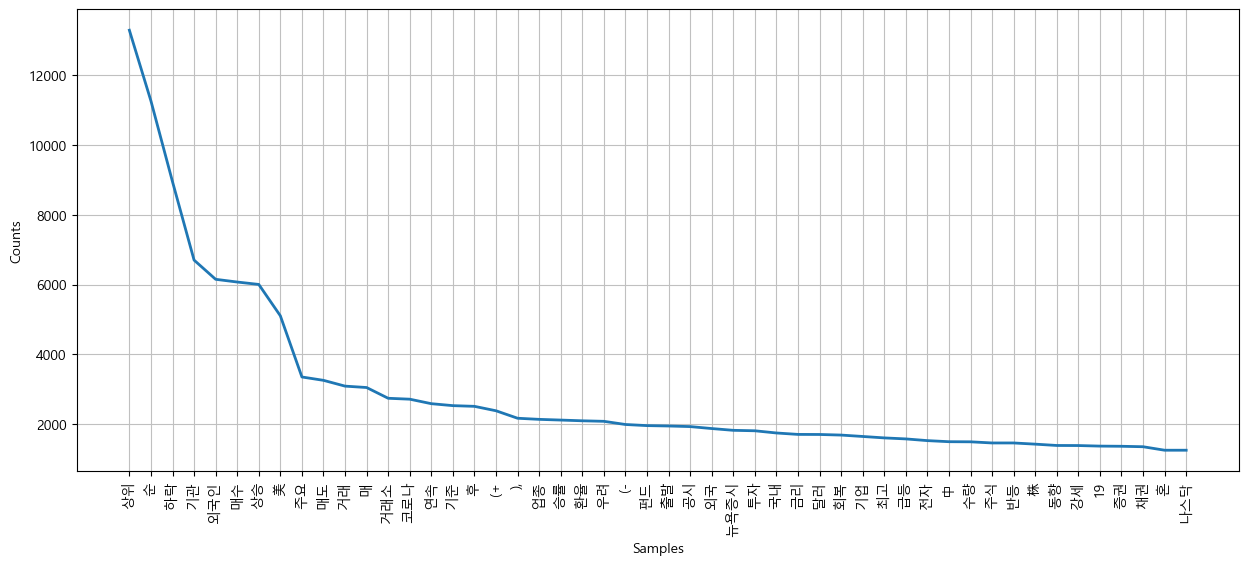

In [34]:
# 자주 등장하는 단어 그래프로 출력
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

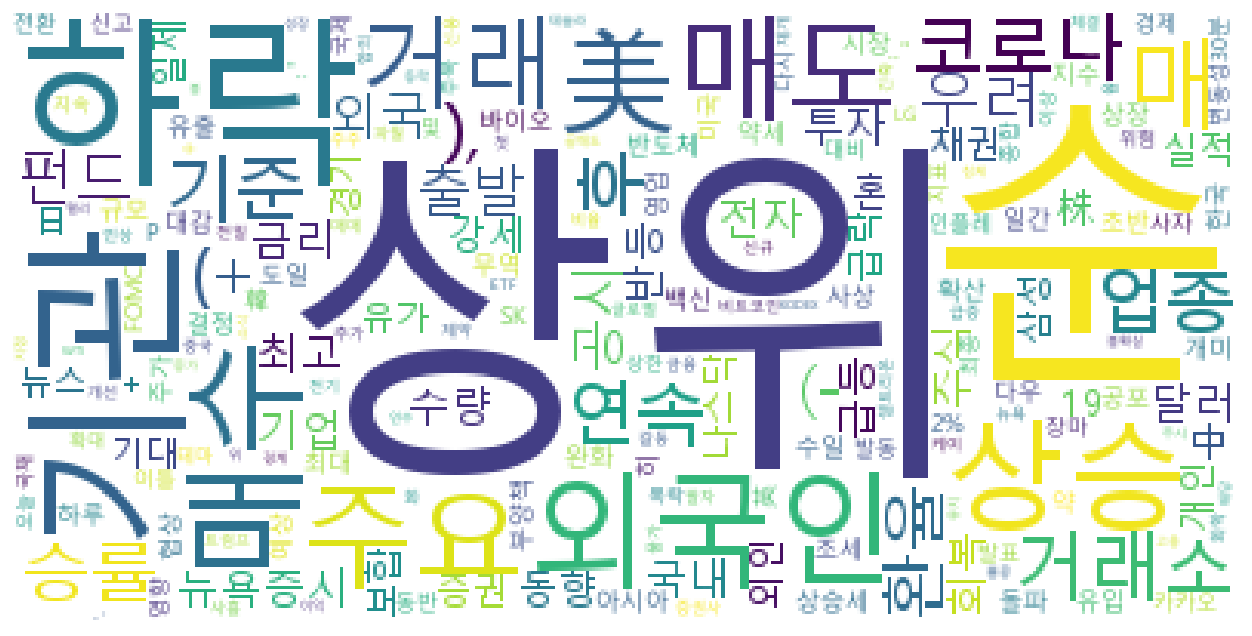

In [35]:
#토큰 워드클라우드 제작
data = ko.vocab().most_common(300)
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                    relative_scaling=0.2,
                    background_color='white').generate_from_frequencies(dict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [36]:
# 형태소 분석을 위한 함수
def tokenizer(text):
    okt = Okt()
    return okt.morphs(text)

def data_preprocessing():
    # 수집한 데이터 읽어오기
    # news_df = pd.read_excel()
    # 학습셋, 테스트셋 분리
    title_list = news_df['뉴스제목'].tolist()
    price_list = news_df['주가변동'].tolist()
    # 데이터의 80%는 학습셋, 20%는 테스트셋
    title_train, title_test, price_train, price_test = train_test_split(title_list, price_list, test_size=0.2, random_state=0)
    return title_train, title_test, price_train, price_test

def learning(x_train, y_train, x_test, y_test):
    # 전처리가 끝난 데이터를 단어 사전으로 만들고
    # 리뷰별로 나오는 단어를 파악해서 수치화 (벡터화)해서 학습
    # tf-idf, 로지스틱 회귀 이용
    tfidf = TfidfVectorizer(lowercase=False, tokenizer=tokenizer)
    # 로지스틱
    logistic = LogisticRegression(C=2, penalty='l2', random_state=0)     # C의 숫자가 너무 크면 과적합 (기본 1), penalty로 과적합 방지
    pipe = Pipeline([('vect',tfidf),('clf',logistic)])
    # 학습
    pipe.fit(x_train, y_train)
    # 학습 정확도 측정
    y_pred = pipe.predict(x_test)
    print(accuracy_score(y_test, y_pred))
    # 학습한 모델을 저장
    with open('pipe.dat', 'wb') as fp:     # 쓰기, 바탕화면에 저장됨
        pickle.dump(pipe, fp)
    print('저장완료')     # 학습된 모델 저장 완료

# 학습 함수
def model_learning():   # 감성분석 모델 생성
    title_train, title_test, price_train, price_test = data_preprocessing()
    learning(title_train, price_train, title_test, price_test)

model_learning()


0.5871548398946917
저장완료


In [37]:
from datetime import date
from Function import news_title_crawling

def model_using(titles):
    
    # 객체를 복원, 저장된 모델 불러오기
    with open('pipe.dat', 'rb') as fp:     # 읽기
        pipe = pickle.load(fp)
    for title in titles:
        print(title)
        # 예측 정확도
        r1 = np.max(pipe.predict_proba(title) * 100)     # 확률값을 구해서 * 100
        # 예측 결과
        r2 = pipe.predict(title)[0]     # 긍정('1'), 부정('0')
        if r2 == 1:
            print('코스피지수는 상승할 것으로 예상됩니다.')
        else: 
            print('코스피지수는 하락할 것으로 예상됩니다.')
        print('정확도 : %.3f' % r1)
        print('------------------------------------------------')

today = []
today.append(str(date.today()).replace('-', ''))
# 모델 확인에 사용한 뉴스 타이틀
titles = news_title_crawling(today,
                base_url='https://finance.naver.com/news/mainnews.naver?date={0}&page={1}',
                news_block='#contentarea_left > div.mainNewsList > ul > li > dl',
                news_title_block='.articleSubject')

model_using(titles)

# 예시 타이틀 -> 10-13일 뉴스 타이틀 
# 코스피, 2년 1개월 만에 최저…물가와 수급에 '털썩' 

['연준 7% 금리 경계심…일제히 하락']
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 58.428
------------------------------------------------
["코스피 외인 '사자'에 소폭 상승…2444선"]
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 52.448
------------------------------------------------
["코스피, 외인 '사자'에 0.06%↑ 2444선 마감"]
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 58.831
------------------------------------------------
['율, 1원 가량 올라 1340원선 상승…달러 반락하며 상승폭 줄여']
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 55.178
------------------------------------------------
['730선 소폭 하락…3거래일째 내리막']
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 60.549
------------------------------------------------
['日반도체주 상승세…금리인상 우려는 여']
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 64.051
------------------------------------------------
['사라지지 않은 긴축 공포…"국내 증시 하락 출발 예상"']
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 67.065
------------------------------------------------
["매파 '불러드'에 달러 강세…환율, 1340원대 상승 예상"]
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 66.456
------------------------------------------------
['"금리 7%까지 인상가능" 신호에 美증시 \'정지\'[뉴욕마감](종합)']
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 76.085